In [22]:
#%pip install optuna

In [128]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [4]:
def ssl_indicator(df):
    sma_high = talib.SMA(df['high'], 10)
    sma_low = talib.SMA(df['low'], 10)
    hlv = [np.nan]
    for i in range(0, len(df['close'])):
        if df['close'][i] > sma_high[i]:
            hlv.append(1)
        elif df['close'][i] < sma_low[i]:
            hlv.append(-1)
        else:
            hlv.append(hlv[i-1])

    ssl_down = [sma_high[i] if hlv[i] < 0 else sma_low[i] for i in range(len(df.close))]
    ssl_up = [sma_low[i] if hlv[i] < 0 else sma_high[i] for i in range(len(df.close))]

    signals = []
    for i in range(0, len(df.close)):
        if ssl_up[i-1] < ssl_down[i-1] and ssl_up[i] > ssl_down[i]:
            signals.append(1)
        elif ssl_up[i-1] > ssl_down[i-1] and ssl_up[i] < ssl_down[i]:
            signals.append(-1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [141]:
def bbands_indicator(df):
    upper_bband_indicator, _, lower_bband_indicator = talib.BBANDS(df["close"], timeperiod=20)

    signals = []
    for i in range(0, len(df.close)):
        if upper_bband_indicator[i] < df['close'][i]:
            signals.append(-1)
        elif lower_bband_indicator[i] > df['close'][i]:
            signals.append(1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

[*********************100%***********************]  1 of 1 completed


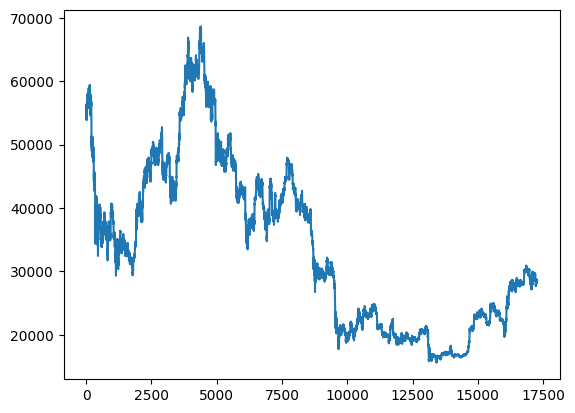

In [142]:
df = getTickerData('btc-usd', '730d', '1h')
df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
#df['date'] = pd.to_datetime(df['date'])

sma100_indicator = talib.SMA(df['close'], timeperiod=100)
mfi_indicator = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
all_ssl_signals, _, _ = ssl_indicator(df=df)
_, macd_signal_indicator, macd_hist_indicator = talib.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)
all_bbands_signals, _, _ = bbands_indicator(df=df)

df['sma_100'] = sma100_indicator
df['mfi'] = mfi_indicator
df['ssl_markover'] = all_ssl_signals
df['macd_signal'] = macd_signal_indicator   
df['macd_hist'] = macd_hist_indicator
df['bbands'] = all_bbands_signals

plt.plot(df['close'])

In [143]:
df = df.drop(columns={'volume', 'Adj Close', 'open', 'high', 'low'})
df = df.dropna()
df

,date,close,sma_100,mfi,ssl_markover,macd_signal,macd_hist,bbands
99,2021-05-08 07:00:00+00:00,58477.312500,56373.898867,58.760382,0,327.833168,37.229990,0
100,2021-05-08 08:00:00+00:00,58862.976562,56411.206836,85.666564,0,345.886475,72.213230,-1
101,2021-05-08 09:00:00+00:00,58824.460938,56441.710195,78.716084,0,367.072263,84.743152,0
102,2021-05-08 10:00:00+00:00,58560.484375,56469.005586,78.716084,0,384.062612,67.961393,0
103,2021-05-08 11:00:00+00:00,58570.785156,56500.013945,78.716084,0,396.821664,51.036209,0
...,...,...,...,...,...,...,...,...
17264,2023-05-03 15:00:00+00:00,28316.931641,28720.921699,20.881108,0,37.668890,-50.053988,0
17265,2023-05-03 16:00:00+00:00,28486.617188,28712.628145,31.904132,0,28.301541,-37.469394,0
17266,2023-05-03 17:00:00+00:00,28534.556641,28703.893125,49.304803,0,22.097531,-24.816042,0
17267,2023-05-03 18:00:00+00:00,28453.234375,28694.916387,32.045374,0,16.853650,-20.975524,0


In [144]:
rn = random.randint(0, df.value_counts().sum()) 
i = 0

20272.78515625


,date,close,sma_100,mfi,ssl_markover,macd_signal,macd_hist,bbands
10190,2022-07-10 15:00:00+00:00,20905.732422,21239.278770,22.125189,0,-100.903002,-44.342305,0
10191,2022-07-10 16:00:00+00:00,20936.269531,21247.527344,27.419910,0,-111.566990,-42.655951,0
10192,2022-07-10 17:00:00+00:00,20901.554688,21254.804551,30.435738,0,-121.707282,-40.561167,0
10193,2022-07-10 18:00:00+00:00,20818.818359,21261.310313,33.505580,0,-132.030374,-41.292371,0
10194,2022-07-10 19:00:00+00:00,20880.656250,21268.877773,21.669008,0,-140.639378,-34.436015,0


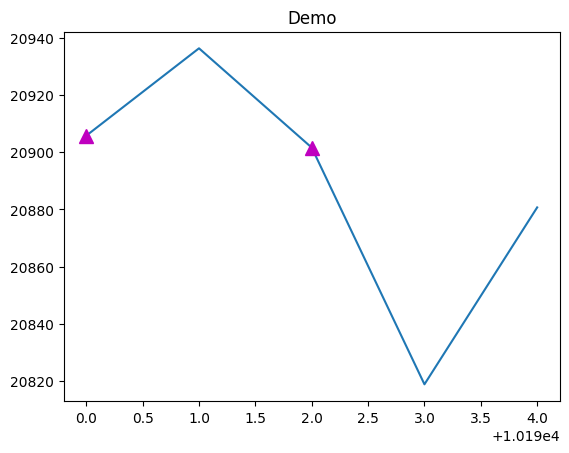

In [145]:
df2 = df.iloc[rn+i:rn+5+i,:]
final_value = df.loc[rn+5+i]['close']
close_value = df.loc[rn+4+i]['close']
plt.plot(df2['close'])
plt.plot(df2['close'], '^', markersize=10, color='m', label = 'buying signal', markevery = [True, False, True, False, False])
plt.title('Demo')
print(final_value)
i+=1
df2

In [146]:
ratio = 20534.63281 / 19985.230469	
ratio2 = 20010.623047 / 20259.931641

trade_fee_bid_percent = 0.01  # unit
trade_fee_ask_percent = 0.005  # unit

cost = np.log((1 - trade_fee_ask_percent) * (1 - trade_fee_bid_percent))
print(cost)

print(ratio)
print(np.log(ratio2))

-0.015062877677045743
1.0274904180791011
-0.012381839835462583


In [147]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2

In [148]:
def qwe(ratio):
    return -np.log(ratio)
ratio = 20534.63281 / 19985.230469	
print(qwe(ratio))

-0.027119341874308964


In [149]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size, desired_winrate) -> None:
        super().__init__()        
        self.df = df.drop(columns={'date'})
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(len(Positions))
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        self.desired_winrate = desired_winrate
        self.positions = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        
    def step(self, action):
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        reward, f, h = self.calculate_reward(action)
            
        if action == Positions.SHORT:
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
        elif action == Positions.LONG:
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
            
        if reward < 0:
            self.loss_positions += 1
            reward *= 2
            
        self.positions.append(action)
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
        
        if self.loss_positions >= self.n_steps - int(self.n_steps * self.desired_winrate):
            done = True
            
        observation = self.get_observation()
        info = {'f': f, 'h': h}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.positions.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def final_render(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        length_of_episode = len(self.positions)
        
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        
        plt.figure(figsize=(20,7))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=6, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
        
        return length_of_episode
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [150]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size, desired_winrate) -> None:
        super().__init__(df, n_steps, window_size, desired_winrate)
    
    def calculate_reward(self, action):
        reward = -0.0000001
        
        if action != Positions.HOLD and self.in_a_pos:
            ratio = self.final_value / self.held_price
            
            if self.current_pos == Positions.SHORT: 
                reward = -np.log(ratio)
                    
            if self.current_pos == Positions.LONG:
                reward = np.log(ratio)
                    
        return reward, self.final_value, self.held_price

In [151]:
env = Trading(df, window_size=90, n_steps=100, desired_winrate=0.7)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


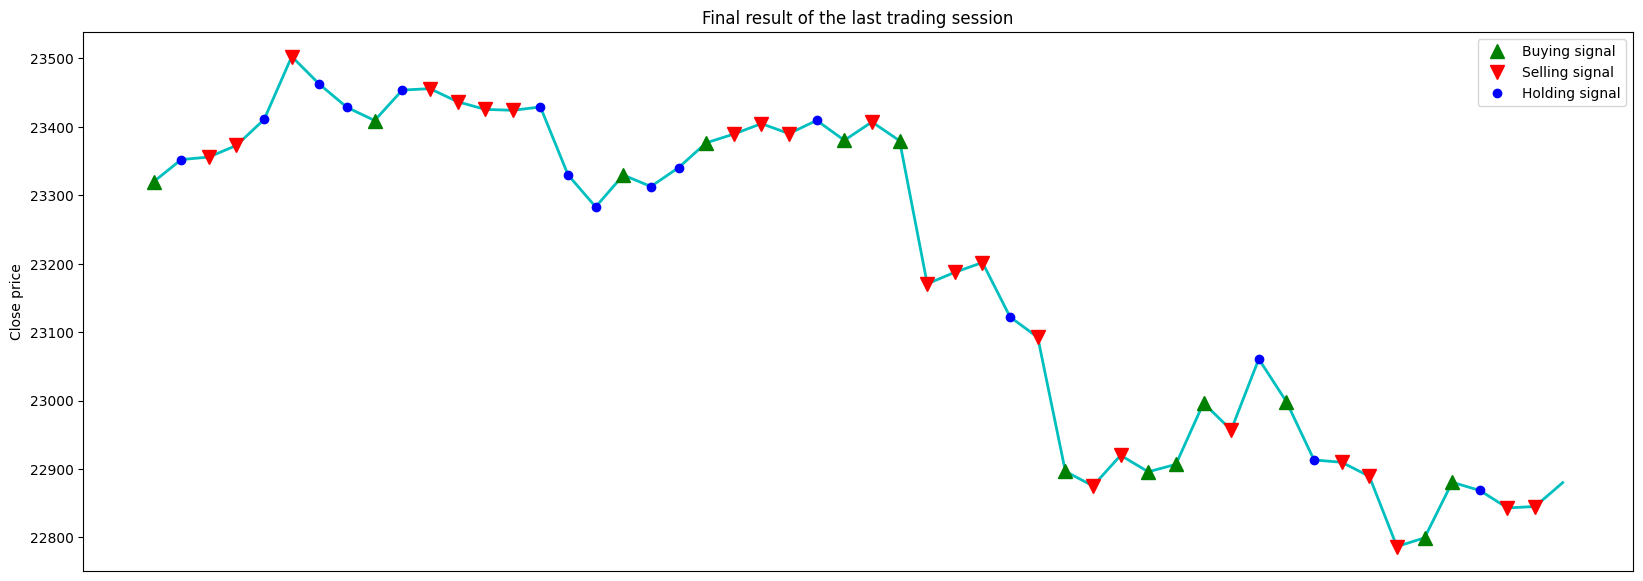

episode - 1 || score - -0.013123592692657261
51


In [152]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
    length_of_episode = env.final_render()
    print(f'episode - {n} || score - {score}')
    print(length_of_episode)

In [153]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [154]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [25]:
def optimize_ppo(trial):
    return {
        'n_steps': trial.suggest_int('n_steps', 2048, 8192),
        'gamma': trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 0.99),
        'ent_coef': trial.suggest_uniform('ent_coef', 0.001, 0.01)
    }

In [26]:
def optimize_agent(trial):
    try:
        model_params=optimize_ppo(trial)
        env = Trading(df, window_size=90, n_steps=100)
        
        model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, **model_params)
        model.learn(100000)
        
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    except Exception as e:
        return -1000

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=35, n_jobs=1)

[I 2023-05-03 10:59:57,649] A new study created in memory with name: no-name-d69a3f95-3753-401a-b25e-55767d8ee9f9
C:\Users\damem\AppData\Local\Temp\ipykernel_11064\1301961368.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 0.8, 0.9999),
C:\Users\damem\AppData\Local\Temp\ipykernel_11064\1301961368.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
C:\Users\damem\AppData\Local\Temp\ipykernel_11064\1301961368.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

KeyboardInterrupt: 

In [89]:
study.best_params

{'n_steps': 7917,
 'gamma': 0.8148319613766952,
 'learning_rate': 1.1494222672968137e-05,
 'clip_range': 0.11454224768088915,
 'gae_lambda': 0.9747187305774679,
 'ent_coef': 0.007806731954039324}

In [156]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, 
                     n_steps=7917,
                     gamma=0.8148319613766952, 
                     learning_rate=1.1494222672968137e-05,
                     clip_range=0.11454224768088915,
                     gae_lambda=0.9747187305774679,
                     ent_coef=0.007806731954039324)

In [19]:
loaded_model = RecurrentPPO.load('./saved_models/best_model_2500000.zip', env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
opt_model = RecurrentPPO.load('./saved_models/opt_model_training_1', env=env)

In [157]:
model.learn(total_timesteps=100000, callback=callback)

In [158]:
evaluate_policy(model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-6.0000000701165845e-06, 0.0)

In [ ]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

In [80]:
evaluate_policy(opt_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-0.006837816031838884, 0.07551070536538326)

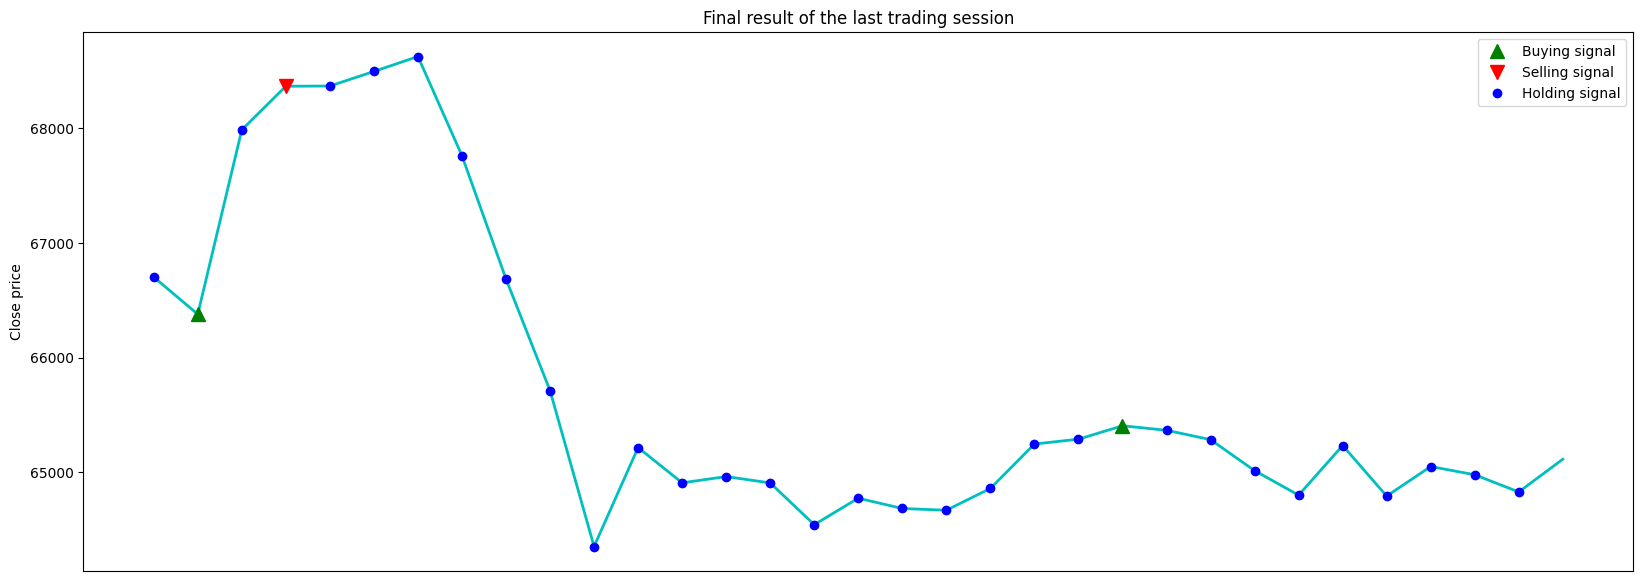

episode - 1 || score - 0.07369928337998649
32


In [166]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    #all_score = []
    while not done:
        action, lstm_cells = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
        #all_score.append(score)
    env.final_render()
    print(f'episode - {n} || score - {score}')
print(steps_taken)